In [112]:
import os
from PIL import Image, ImageDraw
import numpy as np
from torchvision import transforms
import mlflow
import time
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import glob
import torch.optim as optim
import torch.onnx


In [113]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [114]:

def create_center_mask(image_size, max_percentage=10):
    """
    Create a mask with a black square in the center for the region to inpaint.

    Args:
        image_size (tuple): (width, height) of the image.
        max_percentage (float): Maximum percentage of the image area covered by the square.

    Returns:
        Image: Binary mask where 1 (or 255) represents the inpainting region.
    """
    width, height = image_size
    max_area = (width * height) * (max_percentage / 100)  # Maximum area of the square
    side_length = int(max_area ** 0.5)

    # Create an empty mask
    mask = Image.new("L", (width, height), 0)  # Binary mask (0 for background)
    draw = ImageDraw.Draw(mask)

    # Define the square's position
    x0 = (width - side_length) // 2
    y0 = (height - side_length) // 2
    x1 = x0 + side_length
    y1 = y0 + side_length

    # Draw the inpainting region as white (255)
    draw.rectangle([x0, y0, x1, y1], fill=255)

    return mask

# Example: Create a mask
image_size = (224, 224)  # Replace with your image size
mask = create_center_mask(image_size, max_percentage=10)
# mask.show()  # Visualize the mask


In [115]:
normalize_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()  # Convert image to tensor with values in [0, 1]
    # transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])

augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

In [116]:
# # Paths to the dataset
# base_path = "Data"
# vegetable_images_path = os.path.join(base_path, "VegetableImages")
# holed_images_path = os.path.join(base_path, "HoledImages")
# output_normalized_path = "NormalizedData"
# output_augmented_path = "AugmentedData"

# Transformations
# normalize_transform = transforms.Compose([
#     transforms.ToTensor(),  # Convert image to tensor with values in [0, 1]
#     # transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
# ])

# augmentation_transforms = transforms.Compose([
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomRotation(degrees=15),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2),
#     transforms.ToTensor()
# ])

# # Function to process images
# def preprocess_images(input_path, output_path, transform, process_type="normalization"):
#     for root, _, files in os.walk(input_path):
#         for file in files:
#             if file.endswith(('.png', '.jpg', '.jpeg')):  # Add supported image formats
#                 img_path = os.path.join(root, file)
#                 img = Image.open(img_path).convert("RGB")
#                 processed_img = transform(img)
                
#                 # Convert tensor to numpy array for saving
#                 np_img = processed_img.numpy().transpose(1, 2, 0)
                
#                 # Save image in the corresponding output folder
#                 save_path = os.path.join(output_path, os.path.relpath(img_path, input_path))
#                 os.makedirs(os.path.dirname(save_path), exist_ok=True)
#                 Image.fromarray((np_img * 255).astype('uint8')).save(save_path)
#                 print(f"{process_type.capitalize()} processed: {save_path}")

# # MLflow Integration
# mlflow.set_experiment("Image Inpainting Preprocessing")

# with mlflow.start_run(run_name="Preprocessing with better normalization") as run:
#     start_time = time.time()
    
#     # Log parameters for normalization and augmentation
#     mlflow.log_param("Normalization", "[-1, 1]")
#     mlflow.log_param("Augmentation", "RandomHorizontalFlip, RandomRotation, ColorJitter")
    
#     # Normalize VegetableImages
#     print("Normalizing VegetableImages...")
#     preprocess_images(vegetable_images_path, os.path.join(output_normalized_path, "VegetableImages"), normalize_transform, process_type="normalization")
#     mlflow.log_artifacts(os.path.join(output_normalized_path, "VegetableImages"), artifact_path="NormalizedVegetableImages")

#     # Normalize HoledImages
#     print("Normalizing HoledImages...")
#     preprocess_images(holed_images_path, os.path.join(output_normalized_path, "HoledImages"), normalize_transform, process_type="normalization")
#     mlflow.log_artifacts(os.path.join(output_normalized_path, "HoledImages"), artifact_path="NormalizedHoledImages")
    
#     # Augment VegetableImages
#     print("Augmenting VegetableImages...")
#     preprocess_images(vegetable_images_path, os.path.join(output_augmented_path, "VegetableImages"), augmentation_transforms, process_type="augmentation")
#     mlflow.log_artifacts(os.path.join(output_augmented_path, "VegetableImages"), artifact_path="AugmentedVegetableImages")

#     # Augment HoledImages
#     print("Augmenting HoledImages...")
#     preprocess_images(holed_images_path, os.path.join(output_augmented_path, "HoledImages"), augmentation_transforms, process_type="augmentation")
#     mlflow.log_artifacts(os.path.join(output_augmented_path, "HoledImages"), artifact_path="AugmentedHoledImages")
    
#     # Log time taken for preprocessing
#     total_time = time.time() - start_time
#     mlflow.log_metric("Preprocessing_Time_(seconds)", total_time)
#     print(f"Preprocessing completed in {total_time:.2f} seconds.")

In [117]:
# # Log time taken for preprocessing
# total_time = time.time() - start_time
# mlflow.log_metric("Preprocessing_Time_seconds", total_time)
# print(f"Preprocessing completed in {total_time:.2f} seconds.")


In [118]:
mlflow.set_experiment("Image Inpainting with GAN TESTING APPROACH")

<Experiment: artifact_location='file:///c:/Users/mmart/Documents/Studia/SEM5/CV-ImageInpainting/mlruns/153454183242198385', creation_time=1738076830788, experiment_id='153454183242198385', last_update_time=1738076830788, lifecycle_stage='active', name='Image Inpainting with GAN TESTING APPROACH', tags={}>

In [119]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # Encoder layers
        self.enc1 = nn.Sequential(nn.Conv2d(4, 64, kernel_size=4, stride=2, padding=1), nn.ReLU())
        self.enc2 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), nn.BatchNorm2d(128), nn.ReLU())
        self.enc3 = nn.Sequential(nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), nn.BatchNorm2d(256), nn.ReLU())

        # Bottleneck
        self.bottleneck = nn.Sequential(nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1), nn.ReLU())

        # Decoder layers with skip connections
        self.dec1 = nn.Sequential(nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1), nn.BatchNorm2d(256), nn.ReLU())
        self.dec2 = nn.Sequential(nn.ConvTranspose2d(256 + 256, 128, kernel_size=4, stride=2, padding=1), nn.BatchNorm2d(128), nn.ReLU())
        self.dec3 = nn.Sequential(nn.ConvTranspose2d(128 + 128, 64, kernel_size=4, stride=2, padding=1), nn.BatchNorm2d(64), nn.ReLU())
        self.dec4 = nn.Sequential(nn.ConvTranspose2d(64 + 64, 3, kernel_size=4, stride=2, padding=1), nn.Sigmoid())  # Pixel values in [0,1]

    def forward(self, x):
        enc1 = self.enc1(x)  # (B, 64, 112, 112)
        enc2 = self.enc2(enc1)  # (B, 128, 56, 56)
        enc3 = self.enc3(enc2)  # (B, 256, 28, 28)

        bottleneck = self.bottleneck(enc3)  # (B, 512, 14, 14)

        dec1 = self.dec1(bottleneck)  # (B, 256, 28, 28)
        dec2 = self.dec2(torch.cat([dec1, enc3], dim=1))
        dec3 = self.dec3(torch.cat([dec2, enc2], dim=1))
        dec4 = self.dec4(torch.cat([dec3, enc1], dim=1))

        return dec4

generator = Generator().to(device)

In [120]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1), nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2),
            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0), nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x).view(-1)
    
discriminator = Discriminator().to(device)  


In [121]:
# Loss functions
adversarial_loss = nn.BCELoss()  # Binary Cross-Entropy Loss
reconstruction_loss = nn.MSELoss()  # Pixel-wise reconstruction loss

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=5e-5, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=1e-5, betas=(0.5, 0.999))

In [122]:
from torchvision.transforms import ToTensor

def combine_image_and_mask(image, mask):
    """
    Combine an image and its mask into a 4-channel input.

    Args:
        image (PIL.Image): The input image.
        mask (PIL.Image): The binary mask.

    Returns:
        Tensor: 4-channel tensor (image + mask).
    """
    image_tensor = ToTensor()(image)  # Convert image to tensor
    mask_tensor = ToTensor()(mask)  # Convert mask to tensor
    combined = torch.cat((image_tensor, mask_tensor), dim=0)  # Combine along channel dimension
    return combined





In [123]:
class InpaintingDataset(Dataset):
    def __init__(self, holed_dir, ground_truth_dir, mask, transform=None, limit=None):
        """
        Args:
            holed_dir (str): Path to the directory with holed images (e.g., HoledImages/train).
            ground_truth_dir (str): Path to the directory with ground truth images (e.g., VegetableImages/train).
            mask (PIL.Image): Precomputed binary mask for the inpainting region.
            transform (callable, optional): Optional transform to apply to the images.
            limit (int, optional): Limit the number of images used.
        """
        self.holed_paths = sorted(glob.glob(os.path.join(holed_dir, "**", "*.*"), recursive=True))
        self.ground_truth_paths = sorted(glob.glob(os.path.join(ground_truth_dir, "**", "*.*"), recursive=True))
        self.mask = transforms.ToTensor()(mask)  # Convert mask to a tensor
        self.transform = transform

        # Ensure paths match and limit dataset size if needed
        assert len(self.holed_paths) == len(self.ground_truth_paths), "Mismatch between holed and ground truth images"
        if limit:
            self.holed_paths = self.holed_paths[:limit]
            self.ground_truth_paths = self.ground_truth_paths[:limit]

    def __len__(self):
        return len(self.holed_paths)

    def __getitem__(self, idx):
        # Load the holed and ground truth images
        holed_path = self.holed_paths[idx]
        ground_truth_path = self.ground_truth_paths[idx]

        holed_image = Image.open(holed_path).convert("RGB")
        ground_truth_image = Image.open(ground_truth_path).convert("RGB")

        # Apply transforms if provided
        if self.transform:
            holed_image = self.transform(holed_image)
            ground_truth_image = self.transform(ground_truth_image)

        # Ensure the mask has the same spatial dimensions as the image
        mask_tensor = self.mask
        if mask_tensor.shape[-2:] != holed_image.shape[-2:]:
            mask_tensor = torch.nn.functional.interpolate(
                mask_tensor.unsqueeze(0), size=holed_image.shape[-2:]
            ).squeeze(0)

        # Create 4-channel input (holed image + mask)
        combined_input = torch.cat((holed_image, mask_tensor), dim=0)

        return combined_input, ground_truth_image


# Example usage
mask = create_center_mask((224, 224), max_percentage=10)
mask = create_center_mask((224, 224), max_percentage=10)

train_dataset = InpaintingDataset(
    holed_dir="NormalizedData/HoledImages/train",
    ground_truth_dir="NormalizedData/VegetableImages/train",
    mask=mask,
    transform=normalize_transform,
    limit=1000  # Use only 1000 images
)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


# Test the model on one image
test_dataset = InpaintingDataset(
    holed_dir="NormalizedData/HoledImages/test",
    ground_truth_dir="NormalizedData/VegetableImages/test",
    mask=mask,
    transform=normalize_transform,
    limit=100  
)

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)



val_dataset = InpaintingDataset(
    holed_dir="NormalizedData/HoledImages/validation",
    ground_truth_dir="NormalizedData/VegetableImages/validation",
    mask=mask,
    transform=normalize_transform
)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


# Check the data
for combined_input, target in train_loader:
    print(f"Input shape: {combined_input.shape}, Target shape: {target.shape}")
    break


Input shape: torch.Size([64, 4, 128, 128]), Target shape: torch.Size([64, 3, 128, 128])


In [124]:
mask = create_center_mask((224, 224), max_percentage=10)
mask = create_center_mask((224, 224), max_percentage=10)

train_dataset = InpaintingDataset(
    holed_dir="NormalizedData/HoledImages/train",
    ground_truth_dir="NormalizedData/VegetableImages/train",
    mask=mask,
    transform=normalize_transform,
    limit=1000  # Use only 1000 images of beans
)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)



In [125]:
loss_fn = nn.MSELoss()  # Pixel-wise MSE loss


In [126]:
def masked_loss(output, target, mask):
    """
    Compute MSE loss only for the masked region.

    Args:
        output (Tensor): Model output (B, C, H, W).
        target (Tensor): Ground truth image (B, C, H, W).
        mask (Tensor): Binary mask indicating the region to inpaint (B, 1, H, W).

    Returns:
        Tensor: Loss value.
    """
    mask = mask.to(output.device)  # Ensure mask is on the same device
    loss = ((output - target) ** 2) * mask  # Apply the mask
    return loss.sum() / mask.sum()  # Normalize by the number of pixels in the mask


In [127]:
# mlflow.end_run()

In [128]:
# # Initialize model, optimizer, and device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = FastInpaintingModelWithSkip().to(device)
# optimizer = optim.Adam(model.parameters(), lr=1e-3)
# loss_fn = nn.MSELoss()  # Pixel-wise MSE loss


In [129]:
def log_visualizations(test_loader, model, step):
    """
    Generate and save visualizations of the inpainting results to MLflow.

    Args:
        test_loader (DataLoader): Test DataLoader.
        model (torch.nn.Module): Trained inpainting model.
        step (int): Current step or epoch.
    """
    model.eval()
    with torch.no_grad():
        for idx, (combined_input, target) in enumerate(test_loader):
            combined_input, target = combined_input.to(device), target.to(device)
            output = model(combined_input)

            # Extract mask, input image, and ground truth
            input_image = combined_input[:, :3, :, :].cpu().permute(0, 2, 3, 1).numpy()  # (B, H, W, C)
            mask = combined_input[:, 3:4, :, :].cpu().numpy()  # (B, 1, H, W)
            target_image = target.cpu().permute(0, 2, 3, 1).numpy()  # (B, H, W, C)
            output_image = output.cpu().permute(0, 2, 3, 1).numpy()  # (B, H, W, C)

            # Rescale images for visualization
            input_image = (input_image * 255).astype(np.uint8)
            target_image = (target_image * 255).astype(np.uint8)
            output_image = (output_image * 255).astype(np.uint8)

            # Combine inpainted region with the input image
            inpainted_image = input_image[0].copy()
            mask_numpy = mask[0, 0]  # Convert mask to 2D numpy array
            inpainted_image[mask_numpy > 0] = output_image[0][mask_numpy > 0]

            # Save the visualization
            import matplotlib.pyplot as plt
            fig, ax = plt.subplots(1, 3, figsize=(12, 4))
            ax[0].imshow(input_image[0])
            ax[0].set_title("Input (Holed)")
            ax[0].axis("off")

            ax[1].imshow(target_image[0])
            ax[1].set_title("Ground Truth")
            ax[1].axis("off")

            ax[2].imshow(inpainted_image)
            ax[2].set_title("Inpainted Output")
            ax[2].axis("off")

            # Save to a file
            visualization_path = f"./visualizations/epoch_{step}_example_{idx}.png"
            os.makedirs(os.path.dirname(visualization_path), exist_ok=True)
            plt.savefig(visualization_path)
            plt.close()

            # Log to MLflow
            mlflow.log_artifact(visualization_path, artifact_path="visualizations")

            # Log only the first example
            break


In [130]:
# Training Parameters
num_epochs = 20

# Training with MLflow Logging
with mlflow.start_run(run_name="discrimator trained every 2nd batch, 20 epoch") as run:
    run_id = run.info.run_id
    with open("mlflow_run_id.txt", "w") as f:
        f.write(run_id)
    print(f"Run started with ID: {run_id}")

    # Log parameters
    mlflow.log_param("Learning Rate", 1e-3)
    mlflow.log_param("Batch Size", 64)
    mlflow.log_param("Dataset Size", len(train_dataset))
    mlflow.log_param("Number of Epochs", num_epochs)
    mlflow.log_param("Loss Function", "Masked MSE Loss + Adversarial Loss")

    start_time = time.time()
    
    for epoch in range(num_epochs):
        generator.train()
        discriminator.train()

        total_g_loss = 0.0
        total_d_loss = 0.0
        d_updates = 0  # Track how many times D is updated

        for i, (combined_input, target) in enumerate(train_loader):
            combined_input, target = combined_input.to(device), target.to(device)
            mask = combined_input[:, 3:4, :, :]  # Extract the mask channel

            ### ======== Train Discriminator (D) Every 2 Batches ========
            if i % 2 == 0:
                optimizer_D.zero_grad()

                # Get real and fake images
                real_output = discriminator(target)  # Real images
                fake_images = generator(combined_input).detach()  # Generate fake images (detach for D)
                fake_output = discriminator(fake_images)  # Fake images

                # Apply label smoothing
                real_labels = torch.full_like(real_output, 0.9, device=device)  # Label smoothing (0.9 instead of 1.0)
                fake_labels = torch.full_like(fake_output, 0.1, device=device)  # Label smoothing (0.1 instead of 0.0)

                # Compute Discriminator loss
                real_loss = adversarial_loss(real_output, real_labels)
                fake_loss = adversarial_loss(fake_output, fake_labels)
                d_loss = (real_loss + fake_loss) / 2  # Total discriminator loss

                d_loss.backward()
                optimizer_D.step()

                total_d_loss += d_loss.item()
                d_updates += 1  # Increment D update count

            ### ======== Train Generator (G) Every Batch ========
            optimizer_G.zero_grad()

            # Generate fake images and ensure only masked region is modified
            fake_images = mask * generator(combined_input) + (1 - mask) * combined_input[:, :3, :, :]
            fake_output = discriminator(fake_images)

            # Compute Generator loss
            adv_loss = adversarial_loss(fake_output, torch.ones_like(fake_output, device=device))  # Fool D
            recon_loss = masked_loss(fake_images, target, mask)  # Pixel-wise reconstruction loss

            g_loss = adv_loss * 0.05 + recon_loss * 0.95  # Reduce adversarial weight for better convergence
            g_loss.backward()
            optimizer_G.step()

            total_g_loss += g_loss.item()

        # Compute Average Losses
        avg_d_loss = total_d_loss / max(1, d_updates)  # Avoid division by zero
        avg_g_loss = total_g_loss / len(train_loader)

        # Log loss values to MLflow
        mlflow.log_metric("Discriminator Loss", avg_d_loss, step=epoch)
        mlflow.log_metric("Generator Loss", avg_g_loss, step=epoch)

        print(f"Epoch [{epoch + 1}/{num_epochs}], D Loss: {avg_d_loss:.4f}, G Loss: {avg_g_loss:.4f}")
        log_visualizations(test_loader, generator, step=epoch)

    total_training_time = time.time() - start_time
    mlflow.log_metric("Training_Time_seconds", total_training_time)


Run started with ID: 18a52b6c0fa646cbb43e5dc8690807e2
Epoch [1/20], D Loss: 0.7039, G Loss: 0.2018
Epoch [2/20], D Loss: 0.6733, G Loss: 0.1508
Epoch [3/20], D Loss: 0.6515, G Loss: 0.1374
Epoch [4/20], D Loss: 0.6317, G Loss: 0.1290
Epoch [5/20], D Loss: 0.6126, G Loss: 0.1216
Epoch [6/20], D Loss: 0.5943, G Loss: 0.1164
Epoch [7/20], D Loss: 0.5773, G Loss: 0.1095
Epoch [8/20], D Loss: 0.5585, G Loss: 0.1052
Epoch [9/20], D Loss: 0.5422, G Loss: 0.1008
Epoch [10/20], D Loss: 0.5252, G Loss: 0.0969
Epoch [11/20], D Loss: 0.5101, G Loss: 0.0917
Epoch [12/20], D Loss: 0.4924, G Loss: 0.0885
Epoch [13/20], D Loss: 0.4752, G Loss: 0.0849
Epoch [14/20], D Loss: 0.4628, G Loss: 0.0785
Epoch [15/20], D Loss: 0.4497, G Loss: 0.0745
Epoch [16/20], D Loss: 0.4355, G Loss: 0.0721
Epoch [17/20], D Loss: 0.4231, G Loss: 0.0672
Epoch [18/20], D Loss: 0.4113, G Loss: 0.0640
Epoch [19/20], D Loss: 0.4023, G Loss: 0.0601
Epoch [20/20], D Loss: 0.3918, G Loss: 0.0571


In [131]:
# with open("mlflow_run_id.txt", "r") as f:
#     run_id = f.read().strip()
    
# with mlflow.start_run(run_id=run_id):


#     model_save_path = "./models/inpainting_model_weights_autoencoder_skip_fast.pth"
#     torch.save(model.state_dict(), model_save_path)
#     mlflow.log_artifact(model_save_path, artifact_path="models")

#     full_model_save_path = "./models/inpainting_model_full_autoencoder_skip_fast.pth"
#     torch.save(model, full_model_save_path)
#     mlflow.log_artifact(full_model_save_path, artifact_path="models")

In [132]:
def visualize_inpainting(test_loader, model):
    model.eval()
    with torch.no_grad():
        for combined_input, target in test_loader:
            combined_input, target = combined_input.to(device), target.to(device)
            output = model(combined_input)

            # Extract mask, input image, and ground truth
            input_image = combined_input[:, :3, :, :].cpu().permute(0, 2, 3, 1).numpy()  # (B, H, W, C)
            mask = combined_input[:, 3:4, :, :].cpu().numpy()  # (B, 1, H, W)
            target_image = target.cpu().permute(0, 2, 3, 1).numpy()  # (B, H, W, C)
            output_image = output.cpu().permute(0, 2, 3, 1).numpy()  # (B, H, W, C)

            # Rescale images from [0, 1] to [0, 255] for visualization
            input_image = (input_image * 255).astype(np.uint8)
            target_image = (target_image * 255).astype(np.uint8)
            output_image = (output_image * 255).astype(np.uint8)

            # Combine inpainted region with the input image for visualization
            inpainted_image = input_image[0].copy()
            mask_numpy = mask[0, 0]  # Convert mask to 2D numpy array
            inpainted_image[mask_numpy > 0] = output_image[0][mask_numpy > 0]

            # Visualize
            import matplotlib.pyplot as plt
            plt.figure(figsize=(12, 4))

            plt.subplot(1, 3, 1)
            plt.title("Input (Holed)")
            plt.imshow(input_image[0])  # RGB image
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.title("Ground Truth")
            plt.imshow(target_image[0])  # RGB image
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.title("Inpainted Output")
            plt.imshow(inpainted_image)  # RGB image
            plt.axis("off")

            plt.show()
            break


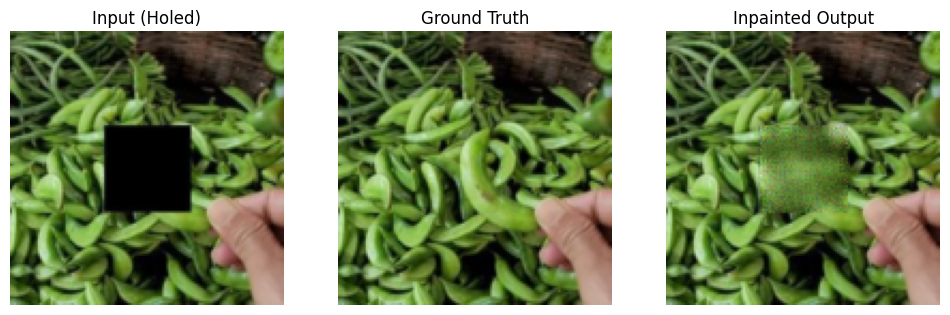

In [133]:


# Visualize the results
visualize_inpainting(test_loader, generator)


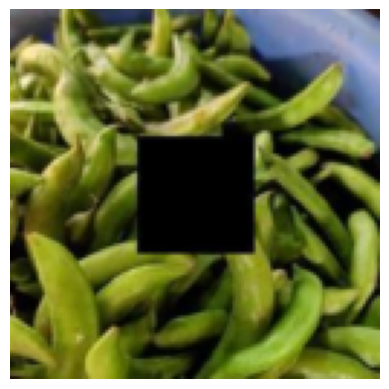

In [134]:
import matplotlib.pyplot as plt

for combined_input, target in test_loader:
    input_image = combined_input[:, :3, :, :].cpu().permute(0, 2, 3, 1).numpy()
    input_image = (input_image * 255).astype(np.uint8)

    plt.imshow(input_image[0])  # Visualize the first image
    plt.axis("off")
    plt.show()
    break


In [135]:
def evaluate_model(test_loader, model, loss_fn, log_to_mlflow=True):
    """
    Evaluate the model on the test dataset.

    Args:
        test_loader (DataLoader): DataLoader for the test dataset.
        model (nn.Module): Trained inpainting model.
        loss_fn (callable): Loss function for evaluation.
        log_to_mlflow (bool): Whether to log the evaluation metrics to MLflow.

    Returns:
        dict: Evaluation results containing test loss and optional metrics.
    """
    model.eval()
    total_loss = 0.0
    total_psnr = 0.0  # For computing PSNR

    num_batches = len(test_loader)
    total_images = num_batches * test_loader.batch_size

    with torch.no_grad():
        for combined_input, target in test_loader:
            combined_input, target = combined_input.to(device), target.to(device)
            mask = combined_input[:, 3:4, :, :]  # Extract the mask channel
            output = model(combined_input)

            # Compute loss
            loss = masked_loss(output, target, mask)
            total_loss += loss.item()

            # Compute additional metrics (e.g., PSNR)
            output_np = (output.cpu().numpy() * 255).astype(np.uint8)
            target_np = (target.cpu().numpy() * 255).astype(np.uint8)
            for b in range(output_np.shape[0]):  # Loop over the batch
                psnr = compute_psnr(output_np[b], target_np[b])
                total_psnr += psnr

    avg_loss = total_loss / num_batches
    avg_psnr = total_psnr / total_images

    # Log results to MLflow
    if log_to_mlflow:
        mlflow.log_metric("Test Loss", avg_loss)
        mlflow.log_metric("Test PSNR", avg_psnr)
        mlflow.log_param("Total Test Images", total_images)  # Log number of images

    # Print results
    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Test PSNR: {avg_psnr:.4f}")
    print(f"Total Test Images: {total_images}")

    return {
        "test_loss": avg_loss,
        "test_psnr": avg_psnr,
        "total_test_images": total_images,
    }


# Helper function to compute PSNR
def compute_psnr(output, target):
    mse = np.mean((output - target) ** 2)
    if mse == 0:
        return float('inf')  # PSNR is infinite if there's no error
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr





In [136]:
with open("mlflow_run_id.txt", "r") as f:
    run_id = f.read().strip()

# Continue the run or start logging to the same run
with mlflow.start_run(run_id=run_id):

# Evaluate the model
    evaluation_results = evaluate_model(test_loader, generator, loss_fn)
mlflow.end_run()

Test Loss: 0.0711
Test PSNR: 21.8370
Total Test Images: 128
